In [1]:
import requests
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as nd
import tensorflow as tf
import tensorflow_hub as hub
import imageio
from google_images_download import google_images_download
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.filters import gaussian
from skimage.measure import ransac
from skimage.transform import AffineTransform
from skimage import color, io
from skimage.exposure import rescale_intensity


Using TensorFlow backend.


In [2]:
module = hub.Module("https://tfhub.dev/google/imagenet/resnet_v1_50/classification/1")
height, width = hub.get_expected_image_size(module)
height, width

Instructions for updating:
Colocations handled automatically by placer.


W0820 15:17:05.678675 4531332544 deprecation.py:323] From /Users/lambda_school_loaner_153/anaconda3/envs/U4-S3-DNN/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


(224, 224)

In [3]:
response = google_images_download.googleimagesdownload()
arguments = {"keywords": "animal national park", "limit": 20,
             "print_urls": True}
absolute_image_paths = response.download(arguments)


Item no.: 1 --> Item name = animal national park
Evaluating...
Starting Download...
Image URL: https://i.ytimg.com/vi/P8NJa_YoRxk/maxresdefault.jpg
Completed Image ====> 1.maxresdefault.jpg
Image URL: https://www.corbettnationalpark.in/blog/wp-content/uploads/2015/08/cropped-13625772024_1fd7467d29_k1.jpg
Completed Image ====> 2.cropped-13625772024_1fd7467d29_k1.jpg
Image URL: https://k6u8v6y8.stackpathcdn.com/blog/wp-content/uploads/2017/06/Royal-Bengal-Tiger.jpg
Completed Image ====> 3.Royal-Bengal-Tiger.jpg
Image URL: https://www.nps.gov/arch/learn/nature/images/ARK_6.jpg?maxwidth=1200&maxheight=1200&autorotate=false
Completed Image ====> 4.ARK_6.jpg
Image URL: https://npca.s3.amazonaws.com/images/8135/2c7e0d75-c7ff-4336-99d7-259448d03a4d-banner.jpg?1445969501
Completed Image ====> 5.2c7e0d75-c7ff-4336-99d7-259448d03a4d-banner.jpg
Image URL: https://greenglobaltravel.com/wp-content/uploads/2017/04/elephant-seal.jpg
Completed Image ====> 6.elephant-seal.jpg
Image URL: https://k6u8v6y

In [4]:
image_list = absolute_image_paths[0]['animal national park']
image_list

['/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal national park/1.maxresdefault.jpg',
 '/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal national park/2.cropped-13625772024_1fd7467d29_k1.jpg',
 '/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal national park/3.Royal-Bengal-Tiger.jpg',
 '/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal national park/4.ARK_6.jpg',
 '/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal national park/5.2c7e0d75-c7ff-4336-99d7-259448d03a4d-banner.jpg',
 '/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal

In [5]:
def resize_image(filename, new_width=224, new_height=224):
    pil_image = Image.open(filename)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert('RGB')
    pil_image_rgb.save(filename, format='JPEG', quality=90)
#     print(filename)
    return filename

In [6]:
images = [resize_image(image) for image in image_list]
images

['/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal national park/1.maxresdefault.jpg',
 '/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal national park/2.cropped-13625772024_1fd7467d29_k1.jpg',
 '/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal national park/3.Royal-Bengal-Tiger.jpg',
 '/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal national park/4.ARK_6.jpg',
 '/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal national park/5.2c7e0d75-c7ff-4336-99d7-259448d03a4d-banner.jpg',
 '/Users/lambda_school_loaner_153/Lambda/DS-Unit-4-Sprint-3-Deep-Learning/module2-convolutional-neural-networks/downloads/animal

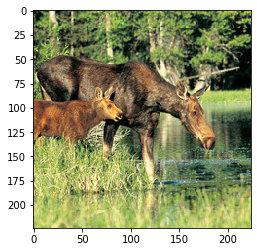

In [7]:
plt.imshow(np.asarray(Image.open(images[11])))

In [8]:
real_images = np.array([np.asarray(Image.open(image)) / 255 for image in images])
real_images.shape

(20, 224, 224, 3)

In [9]:
real_images.shape

(20, 224, 224, 3)

In [10]:
logits = module(real_images)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0820 15:17:26.894650 4531332544 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [11]:
target_map = requests.get('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt').content

In [12]:
str(target_map).split('\\n')

['b"background',
 'tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house finch',
 'junco',
 'indigo bunting',
 'robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel',
 'kite',
 'bald eagle',
 'vulture',
 'great grey owl',
 'European fire salamander',
 'common newt',
 'eft',
 'spotted salamander',
 'axolotl',
 'bullfrog',
 'tree frog',
 'tailed frog',
 'loggerhead',
 'leatherback turtle',
 'mud turtle',
 'terrapin',
 'box turtle',
 'banded gecko',
 'common iguana',
 'American chameleon',
 'whiptail',
 'agama',
 'frilled lizard',
 'alligator lizard',
 'Gila monster',
 'green lizard',
 'African chameleon',
 'Komodo dragon',
 'African crocodile',
 'American alligator',
 'triceratops',
 'thunder snake',
 'ringneck snake',
 'hognose snake',
 'green snake',
 'king snake',
 'garter snake',
 'water snake',
 'vine snake',
 'night snake',
 'boa constrictor',
 'rock pytho

In [13]:
lookup = [target.strip(r"'b'").strip(r'"') for target in str(target_map).split('\\n')]

In [18]:
logits[4]

<tf.Tensor 'strided_slice_22:0' shape=(1001,) dtype=float32>

In [30]:
lookup[np.argmax(logits[11])]

'background'